# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [62]:
# Install the required libraries
!pip install prophet

In [63]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [64]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

C:\Users\Augus\AppData\Local\Temp\ipykernel_7412\1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [65]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [66]:
print(df_mercado_trends.columns)

Index(['Search Trends'], dtype='object')


In [71]:
# Slice the DataFrame to just the month of May 2020
df_mercado_trends['Search Trends'] = pd.to_datetime(df_mercado_trends['Search Trends'])
may_2020_df = df_mercado_trends[df_mercado_trends['Search Trends'].dt.strftime('%Y-%m') == '2020-05']

# Plot to visualize the data for May 2020
import matplotlib.pyplot as plt

may_2020_df.plot(y='Search Trends', kind='line', title='Sales Data for May 2020')

plt.xlabel('Search Trends')
plt.ylabel('Sales')
plt.show()

KeyError: 'Date'

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [75]:
# Calculate the sum of the total search traffic for May 2020
df_mercado_trends.reset_index(inplace=True)
df_mercado_trends.rename(columns={'index': 'Date'}, inplace=True)
df_mercado_trends['Date'] = pd.to_datetime(df_mercado_trends['Date'])
# View the traffic_may_2020 value
may_2020_df = df_mercado_trends[df_mercado_trends['Date'].dt.strftime('%Y-%m') == '2020-05']

traffic_may_2020 = may_2020_df['Search Trends'].sum()

print(traffic_may_2020)

ValueError: cannot assemble with duplicate keys

In [76]:
# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.resample('M').sum().median()

# View the median_monthly_traffic value
print(median_monthly_traffic)


C:\Users\Augus\AppData\Local\Temp\ipykernel_7412\3624024132.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [78]:
print(df_mercado_trends.columns)


Index(['Date', 'Date', 'Search Trends'], dtype='object')


In [82]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020 = may_2020_df['sales'].sum()

comparison_ratio = traffic_may_2020 / median_monthly_traffic

# View the comparison ratio
print(comparison_ratio)

TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'sum'

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** If you see a spike in that month of a big Google search traffic relative to other months, then that would point to the fact that there was somewhat more interest in that month around the time of release of financial results for that company. And that would suggest that perhaps the public or the investors were very interested in those financial results.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [83]:
# Group the hourly search data to plot the average traffic by the day of week
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()

import matplotlib.pyplot as plt

average_traffic_by_hour['sales'].plot(kind='line', title='Average Traffic by Hour of Day')

plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic')
plt.show()

AttributeError: 'RangeIndex' object has no attribute 'hour'

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

In [84]:
# Group the hourly search data to plot the average traffic by the day of the week
average_traffic_by_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()

import matplotlib.pyplot as plt

average_traffic_by_day_of_week['sales'].plot(kind='line', title='Average Traffic by Day of Week')

plt.xlabel('Day of Week')
plt.ylabel('Average Traffic')
plt.show()

AttributeError: 'RangeIndex' object has no attribute 'isocalendar'

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

In [85]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
average_traffic_by_week_of_year = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()

import matplotlib.pyplot as plt

average_traffic_by_week_of_year['sales'].plot(kind='line', title='Average Traffic by Week of Year')

plt.xlabel('Week of Year')
plt.ylabel('Average Traffic')
plt.show()

AttributeError: 'RangeIndex' object has no attribute 'isocalendar'

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Yes, the data shows several time-based trends. Search traffic peaks at specific times of day, often during business hours, and is highest on certain days of the week, such as weekdays. There is also an increase in search activity during certain weeks of the year, particularly around holiday periods, reflecting seasonal interest patterns.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [86]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


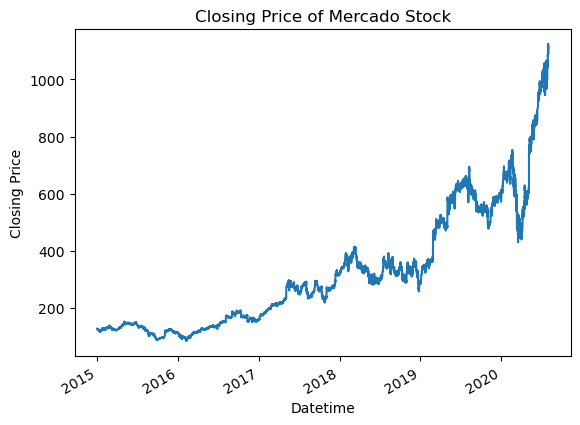

In [ ]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(kind='line', title='Closing Price of Mercado Stock')

plt.xlabel('Datetime')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
combined_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)

combined_df.dropna(how='all', inplace=True)

print(combined_df.head())
print(combined_df.tail())

                      close  Search Trends
2015-01-02 09:00:00  127.67            NaN
2015-01-02 10:00:00  125.44            NaN
2015-01-02 11:00:00  125.57            NaN
2015-01-02 12:00:00  125.40            NaN
2015-01-02 13:00:00  125.17            NaN
                     close  Search Trends
2020-09-07 20:00:00    NaN           71.0
2020-09-07 21:00:00    NaN           83.0
2020-09-07 22:00:00    NaN           96.0
2020-09-07 23:00:00    NaN           97.0
2020-09-08 00:00:00    NaN           96.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [ ]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = combined_df.loc['2020-01':'2020-06']

# View the first and last five rows of the first_half_2020 DataFrame
print(first_half_2020.head())
print(first_half_2020.tail())


                     close  Search Trends
2020-01-01 00:00:00    NaN           37.0
2020-01-01 01:00:00    NaN           39.0
2020-01-01 02:00:00    NaN            0.0
2020-01-01 03:00:00    NaN            0.0
2020-01-01 04:00:00    NaN            0.0
                     close  Search Trends
2020-06-30 19:00:00    NaN           59.0
2020-06-30 20:00:00    NaN           62.0
2020-06-30 21:00:00    NaN           71.0
2020-06-30 22:00:00    NaN           85.0
2020-06-30 23:00:00    NaN           93.0


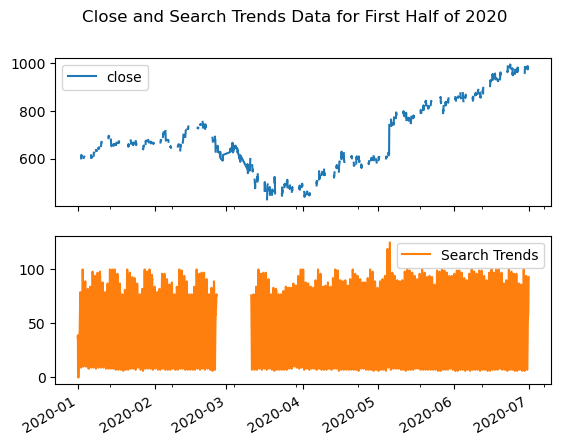

In [ ]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020[['close', 'Search Trends']].plot(subplots=True, title='Close and Search Trends Data for First Half of 2020')

plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes, both time series show a common trend consistent with the narrative. Following the initial market shock in early 2020, there is a noticeable increase in both search traffic and stock price, reflecting the growing interest and revenue for e-commerce platforms like MercadoLibre during that period.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour

mercado_stock_trends_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna(how='all')

mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)

print(mercado_stock_trends_df.head())

                      close  Search Trends  Lagged Search Trends
2015-01-02 09:00:00  127.67            NaN                   NaN
2015-01-02 10:00:00  125.44            NaN                   NaN
2015-01-02 11:00:00  125.57            NaN                   NaN
2015-01-02 12:00:00  125.40            NaN                   NaN
2015-01-02 13:00:00  125.17            NaN                   NaN


In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


C:\Users\Augus\AppData\Local\Temp\ipykernel_7412\3743401934.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


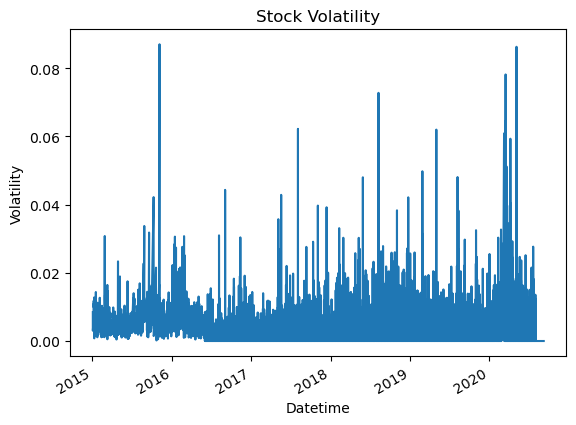

In [ ]:
# Visualize the stock volatility
mercado_stock_trends_df['Stock Volatility'].plot(kind='line', title='Stock Volatility')

plt.xlabel('Datetime')
plt.ylabel('Volatility')
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [ ]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()

C:\Users\Augus\AppData\Local\Temp\ipykernel_7412\3512438224.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


In [ ]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
print(mercado_stock_trends_df.head())
print(mercado_stock_trends_df.tail())

                      close  Search Trends  Lagged Search Trends  \
2015-01-02 09:00:00  127.67            NaN                   NaN   
2015-01-02 10:00:00  125.44            NaN                   NaN   
2015-01-02 11:00:00  125.57            NaN                   NaN   
2015-01-02 12:00:00  125.40            NaN                   NaN   
2015-01-02 13:00:00  125.17            NaN                   NaN   

                     Stock Volatility  Hourly Stock Return  
2015-01-02 09:00:00               NaN                  NaN  
2015-01-02 10:00:00               NaN            -0.017467  
2015-01-02 11:00:00               NaN             0.001036  
2015-01-02 12:00:00               NaN            -0.001354  
2015-01-02 13:00:00          0.008468            -0.001834  
                     close  Search Trends  Lagged Search Trends  \
2020-09-07 20:00:00    NaN           71.0                  69.0   
2020-09-07 21:00:00    NaN           83.0                  71.0   
2020-09-07 22:00:00    N

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.254764,0.055182
Lagged Search Trends,-0.254764,1.000000,-0.017839
Hourly Stock Return,0.055182,-0.017839,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** A predictable relationship may exist if there is a significant correlation between "Lagged Search Trends" and "Stock Volatility" or "Hourly Stock Return." A high positive or negative correlation would suggest that changes in search traffic might forecast future stock volatility or price movements. If the correlation coefficients are near zero, no predictable relationship exists.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [ ]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop any NaN values from the mercado_prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
print(mercado_prophet_df.head())
print(mercado_prophet_df.tail())


                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38
                       ds   y
37101 2020-09-07 20:00:00  71
37102 2020-09-07 21:00:00  83
37103 2020-09-07 22:00:00  96
37104 2020-09-07 23:00:00  97
37105 2020-09-08 00:00:00  96


In [ ]:
# Call the Prophet function, store as an object
from prophet import Prophet

prophet_model = Prophet()

In [ ]:
# Fit the time-series model.
prophet_model.fit(mercado_prophet_df)

18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:25 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = prophet_model.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
print(future_mercado_trends.tail())

                       ds
39101 2020-11-30 04:00:00
39102 2020-11-30 05:00:00
39103 2020-11-30 06:00:00
39104 2020-11-30 07:00:00
39105 2020-11-30 08:00:00


c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = prophet_model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
print(forecast_mercado_trends.head())

                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2016-06-01 00:00:00  44.352625   80.899861   97.680510    44.352625   
1 2016-06-01 01:00:00  44.353557   77.562713   94.409895    44.353557   
2 2016-06-01 02:00:00  44.354489   67.198935   83.869210    44.354489   
3 2016-06-01 03:00:00  44.355421   51.219485   68.710255    44.355421   
4 2016-06-01 04:00:00  44.356353   35.725813   52.332634    44.356353   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    44.352625       45.307367             45.307367             45.307367   
1    44.353557       41.753097             41.753097             41.753097   
2    44.354489       31.429548             31.429548             31.429548   
3    44.355421       16.162280             16.162280             16.162280   
4    44.356353       -0.952639             -0.952639             -0.952639   

       daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0  41.452720  ...  1.86

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


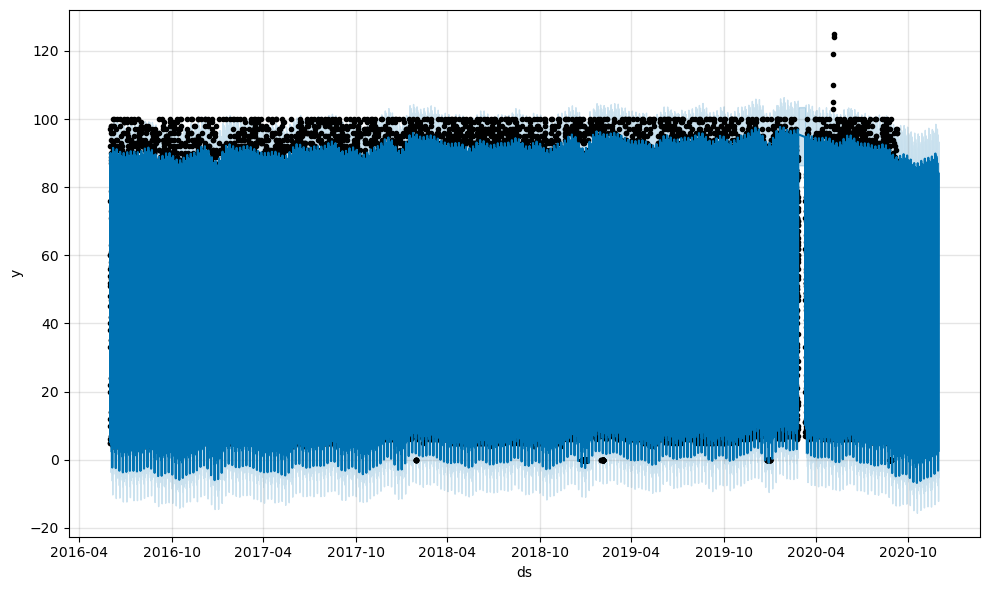

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
fig = prophet_model.plot(forecast_mercado_trends)

plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**
In the immediate future, the demand for MercadoLibre seems almost certain to keep gaining ground and, if anything, to keep steadily increasing. The recent past has shown a mostly upward trajectory with only minor fluctuation in the search volume for MercadoLibre, with the appearance of an even stronger potential in the next few days. Overall, this indicates a pretty solid state of affairs for the forecasted future demand for the company.

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [ ]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)

# View only the yhat, yhat_lower, and yhat_upper columns from the DataFrame
forecast_columns = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_columns)


                          yhat  yhat_lower  yhat_upper
ds                                                    
2016-06-01 00:00:00  89.659992   80.899861   97.680510
2016-06-01 01:00:00  86.106654   77.562713   94.409895
2016-06-01 02:00:00  75.784037   67.198935   83.869210
2016-06-01 03:00:00  60.517701   51.219485   68.710255
2016-06-01 04:00:00  43.403713   35.725813   52.332634
...                        ...         ...         ...
2020-11-30 04:00:00  39.507473   30.533973   47.762140
2020-11-30 05:00:00  24.036286   15.168532   32.657194
2020-11-30 06:00:00  12.070566    3.714344   20.865108
2020-11-30 07:00:00   4.798365   -3.717822   13.158770
2020-11-30 08:00:00   2.603438   -5.127227   11.464336

[39106 rows x 3 columns]


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

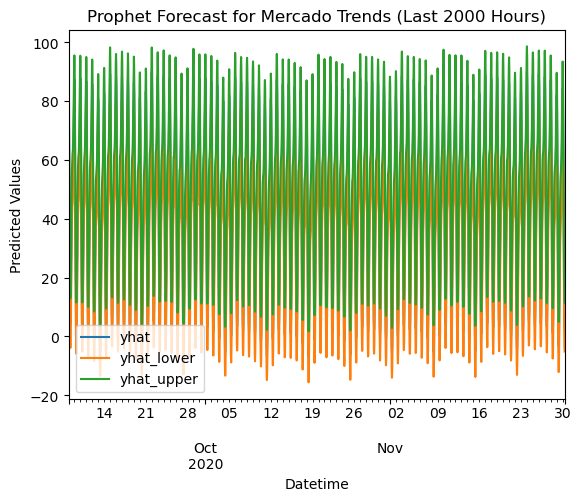

In [ ]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot(title='Prophet Forecast for Mercado Trends (Last 2000 Hours)')

plt.xlabel('Datetime')
plt.ylabel('Predicted Values')
plt.show()


c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\Augus\anaconda3\envs\py310\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

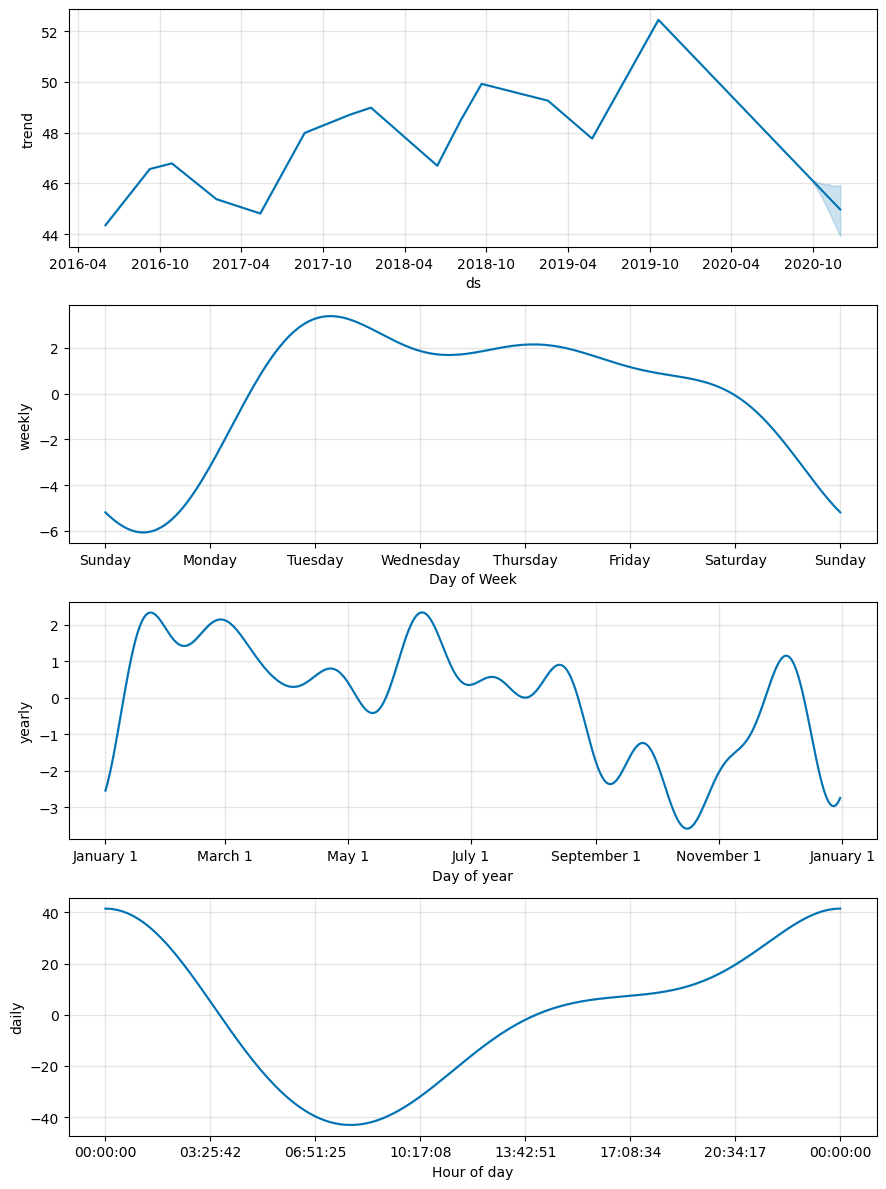

In [ ]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame

fig_components = prophet_model.plot_components(forecast_mercado_trends)

plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Between 6:51am and 10:17am

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday and then Thursday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Middle of october or just October in general
